### Import das bibliotecas

In [6]:
import pandas as pd
import numpy as np
import seaborn
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from google.colab import files
import io

### Leitura dos arquivos

In [7]:
# Carregar o arquivo
uploaded = files.upload()
# Especificar a codificação correta
df = pd.read_csv(io.BytesIO(uploaded['ofertas_relampago.csv']), encoding='ISO-8859-1')

Saving ofertas_relampago.csv to ofertas_relampago (1).csv


### Avaliação da base

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48746 entries, 0 to 48745
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   OFFER_START_DATE           48746 non-null  object 
 1   OFFER_START_DTTM           48746 non-null  object 
 2   OFFER_FINISH_DTTM          48746 non-null  object 
 3   OFFER_TYPE                 48746 non-null  object 
 4   INVOLVED_STOCK             48746 non-null  int64  
 5   REMAINING_STOCK_AFTER_END  48746 non-null  int64  
 6   SOLD_AMOUNT                24579 non-null  float64
 7   SOLD_QUANTITY              24579 non-null  float64
 8   ORIGIN                     11316 non-null  object 
 9   SHIPPING_PAYMENT_TYPE      48746 non-null  object 
 10  DOM_DOMAIN_AGG1            48746 non-null  object 
 11  VERTICAL                   48746 non-null  object 
 12  DOMAIN_ID                  48746 non-null  object 
dtypes: float64(2), int64(2), object(9)
memory usag

In [ ]:
df.describe()

,INVOLVED_STOCK,REMAINING_STOCK_AFTER_END,SOLD_AMOUNT,SOLD_QUANTITY
count,48746.000000,48746.000000,24579.000000,24579.000000
mean,35.007508,30.565216,51.208898,10.851052
std,206.761058,195.813806,175.254414,45.475305
min,1.000000,-192.000000,0.280000,1.000000
25%,5.000000,4.000000,5.730000,1.000000
50%,10.000000,8.000000,12.420000,3.000000
75%,15.000000,15.000000,30.925000,6.000000
max,9000.000000,8635.000000,4836.570000,1646.000000


In [ ]:
df.head()

,OFFER_START_DATE,OFFER_START_DTTM,OFFER_FINISH_DTTM,OFFER_TYPE,INVOLVED_STOCK,REMAINING_STOCK_AFTER_END,SOLD_AMOUNT,SOLD_QUANTITY,ORIGIN,SHIPPING_PAYMENT_TYPE,DOM_DOMAIN_AGG1,VERTICAL,DOMAIN_ID
0,2021-06-22,2021-06-22 16:00:00+00:00,2021-06-22 23:02:43+00:00,lightning_deal,4,-2,4.72,6.0,A,none,PETS FOOD,CPG,MLM-BIRD_FOODS
1,2021-06-22,2021-06-22 13:00:00+00:00,2021-06-22 19:00:02+00:00,lightning_deal,5,5,NaN,NaN,NaN,free_shipping,PET PRODUCTS,OTHERS,MLM-ANIMAL_AND_PET_PRODUCTS
2,2021-06-22,2021-06-22 07:00:00+00:00,2021-06-22 13:00:01+00:00,lightning_deal,15,12,10.73,3.0,NaN,none,COMPUTERS,CE,MLM-SPEAKERS
3,2021-06-22,2021-06-22 19:00:00+00:00,2021-06-23 01:36:12+00:00,lightning_deal,15,13,7.03,2.0,NaN,none,COMPUTERS,CE,MLM-HEADPHONES
4,2021-06-22,2021-06-22 13:00:00+00:00,2021-06-22 15:48:12+00:00,lightning_deal,15,0,39.65,15.0,NaN,none,COMPUTERS,CE,MLM-HEADPHONES


### Pré Processamento

In [8]:
# verificar linhas duplicadas
df.duplicated().sum()

926

In [9]:
df = df.drop_duplicates()

In [10]:
# avaliar e tratar valores nulos
# ORIGIN: temos dados apenas com a classe A, nesse caso vou utilizar o valor mais comum que é o A para os valores nulos

In [11]:
moda = df['ORIGIN'].mode()
df['ORIGIN'] = np.where(df['ORIGIN'].isnull(), moda, df['ORIGIN'])

In [12]:
# SOLD_AMOUNT e SOLD_QUANTITY: os valores médios dessas variáveis de acordo com a vertical possui muita variação, com isso
# decidi inputar a média de acordo com a vertical para ficar mais próximo da realidade

In [13]:
for coluna in df[['SOLD_QUANTITY', 'SOLD_AMOUNT']].columns:
    for vertical in df['VERTICAL'].unique():
        df[coluna].replace(np.nan, df[coluna][df['VERTICAL'] == vertical].mean(),inplace = True)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47820 entries, 0 to 48745
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   OFFER_START_DATE           47820 non-null  object 
 1   OFFER_START_DTTM           47820 non-null  object 
 2   OFFER_FINISH_DTTM          47820 non-null  object 
 3   OFFER_TYPE                 47820 non-null  object 
 4   INVOLVED_STOCK             47820 non-null  int64  
 5   REMAINING_STOCK_AFTER_END  47820 non-null  int64  
 6   SOLD_AMOUNT                47820 non-null  float64
 7   SOLD_QUANTITY              47820 non-null  float64
 8   ORIGIN                     47820 non-null  object 
 9   SHIPPING_PAYMENT_TYPE      47820 non-null  object 
 10  DOM_DOMAIN_AGG1            47820 non-null  object 
 11  VERTICAL                   47820 non-null  object 
 12  DOMAIN_ID                  47820 non-null  object 
dtypes: float64(2), int64(2), object(9)
memory usag

### Feature Engineering

#### Criação da feature de duração da oferta relâmpago

In [16]:
df['OFFER_START_DTTM'] = pd.to_datetime(df['OFFER_START_DTTM'])
df['OFFER_FINISH_DTTM'] = pd.to_datetime(df['OFFER_FINISH_DTTM'])

In [17]:
df['OFFER_DURATION'] = df['OFFER_FINISH_DTTM'] - df['OFFER_START_DTTM']

In [18]:
to_hours = lambda x: x.total_seconds() / 3600

In [20]:
df['OFFER_DURATION_HOURS'] = df['OFFER_DURATION'].apply(to_hours)
df['OFFER_DURATION_HOURS'] = df['OFFER_DURATION_HOURS'].astype(int)

### Identificação e análise de outlier

In [21]:
df.sort_values(by='OFFER_DURATION_HOURS', ascending=False).head(3)

,OFFER_START_DATE,OFFER_START_DTTM,OFFER_FINISH_DTTM,OFFER_TYPE,INVOLVED_STOCK,REMAINING_STOCK_AFTER_END,SOLD_AMOUNT,SOLD_QUANTITY,ORIGIN,SHIPPING_PAYMENT_TYPE,DOM_DOMAIN_AGG1,VERTICAL,DOMAIN_ID,OFFER_DURATION,OFFER_DURATION_HOURS
42018,2021-06-05,2021-06-05 13:00:00+00:00,2021-06-09 21:45:09+00:00,lightning_deal,5,5,13.915174,4.725914,A,none,APPAREL ACCESORIES,APP & SPORTS,MLM-SLEEPING_MASKS,4 days 08:45:09,104
28642,2021-07-21,2021-07-21 18:00:00+00:00,2021-07-22 09:37:09+00:00,lightning_deal,100,100,13.915174,4.725914,A,free_shipping,MOBILE,CE,MLM-TABLETS,0 days 15:37:09,15
28556,2021-07-21,2021-07-21 19:00:00+00:00,2021-07-22 09:40:07+00:00,lightning_deal,10,9,4.880000,1.000000,A,free_shipping,PERSONAL HYGIENE,CPG,MLM-HAIR_SHAMPOOS_AND_CONDITIONERS,0 days 14:40:07,14


In [22]:
df[df['OFFER_DURATION_HOURS'] == 104]

,OFFER_START_DATE,OFFER_START_DTTM,OFFER_FINISH_DTTM,OFFER_TYPE,INVOLVED_STOCK,REMAINING_STOCK_AFTER_END,SOLD_AMOUNT,SOLD_QUANTITY,ORIGIN,SHIPPING_PAYMENT_TYPE,DOM_DOMAIN_AGG1,VERTICAL,DOMAIN_ID,OFFER_DURATION,OFFER_DURATION_HOURS
42018,2021-06-05,2021-06-05 13:00:00+00:00,2021-06-09 21:45:09+00:00,lightning_deal,5,5,13.915174,4.725914,A,none,APPAREL ACCESORIES,APP & SPORTS,MLM-SLEEPING_MASKS,4 days 08:45:09,104


In [23]:
df[df['DOMAIN_ID'] == 'MLM-SLEEPING_MASKS']

,OFFER_START_DATE,OFFER_START_DTTM,OFFER_FINISH_DTTM,OFFER_TYPE,INVOLVED_STOCK,REMAINING_STOCK_AFTER_END,SOLD_AMOUNT,SOLD_QUANTITY,ORIGIN,SHIPPING_PAYMENT_TYPE,DOM_DOMAIN_AGG1,VERTICAL,DOMAIN_ID,OFFER_DURATION,OFFER_DURATION_HOURS
4667,2021-07-23,2021-07-23 14:00:00+00:00,2021-07-23 22:00:00+00:00,lightning_deal,12,12,13.915174,4.725914,A,free_shipping,APPAREL ACCESORIES,APP & SPORTS,MLM-SLEEPING_MASKS,0 days 08:00:00,8
12479,2021-07-30,2021-07-30 16:00:00+00:00,2021-07-31 00:00:00+00:00,lightning_deal,6,5,1.660000,1.000000,A,none,APPAREL ACCESORIES,APP & SPORTS,MLM-SLEEPING_MASKS,0 days 08:00:00,8
13624,2021-07-19,2021-07-19 15:00:00+00:00,2021-07-19 23:00:00+00:00,lightning_deal,6,4,3.640000,2.000000,A,none,APPAREL ACCESORIES,APP & SPORTS,MLM-SLEEPING_MASKS,0 days 08:00:00,8
22932,2021-06-07,2021-06-07 07:00:00+00:00,2021-06-07 07:00:01+00:00,lightning_deal,15,15,13.915174,4.725914,A,none,APPAREL ACCESORIES,APP & SPORTS,MLM-SLEEPING_MASKS,0 days 00:00:01,0
25749,2021-07-18,2021-07-18 14:00:00+00:00,2021-07-18 22:00:00+00:00,lightning_deal,15,15,13.915174,4.725914,A,free_shipping,APPAREL ACCESORIES,APP & SPORTS,MLM-SLEEPING_MASKS,0 days 08:00:00,8
25750,2021-07-18,2021-07-18 14:00:00+00:00,2021-07-18 22:00:00+00:00,lightning_deal,8,8,13.915174,4.725914,A,free_shipping,APPAREL ACCESORIES,APP & SPORTS,MLM-SLEEPING_MASKS,0 days 08:00:00,8
26502,2021-06-17,2021-06-17 10:00:00+00:00,2021-06-17 18:00:00+00:00,lightning_deal,5,5,13.915174,4.725914,A,none,APPAREL ACCESORIES,APP & SPORTS,MLM-SLEEPING_MASKS,0 days 08:00:00,8
28457,2021-07-21,2021-07-21 13:00:00+00:00,2021-07-21 21:00:00+00:00,lightning_deal,4,3,1.680000,1.000000,A,none,APPAREL ACCESORIES,APP & SPORTS,MLM-SLEEPING_MASKS,0 days 08:00:00,8
42018,2021-06-05,2021-06-05 13:00:00+00:00,2021-06-09 21:45:09+00:00,lightning_deal,5,5,13.915174,4.725914,A,none,APPAREL ACCESORIES,APP & SPORTS,MLM-SLEEPING_MASKS,4 days 08:45:09,104


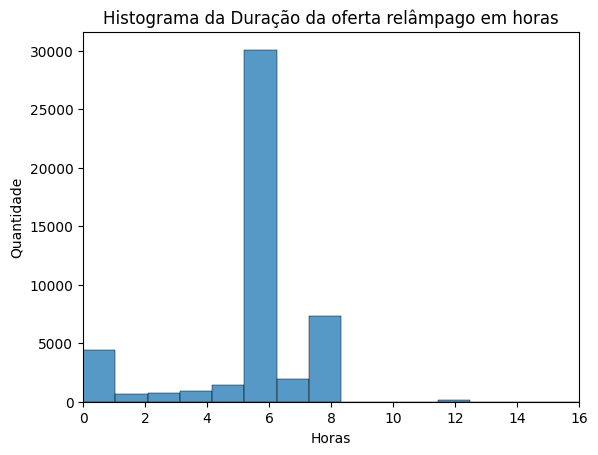

In [24]:
# análise da distribuição da variável criada
sns.histplot(data=df['OFFER_DURATION_HOURS'], kde=False, bins=100)
sns.set(style="darkgrid")
plt.xlim(0, 16)
plt.xlabel('Horas')
plt.ylabel('Quantidade')
plt.title('Histograma da Duração da oferta relâmpago em horas')
plt.show()

#### Criação da feature de receita/quantidade

In [25]:
df['AMOUNT_BY_QUANTITY'] = df['SOLD_AMOUNT'] / df['SOLD_QUANTITY']

#### Criação da feature Dia inicial da oferta relâmpago

In [26]:
df['OFFER_START_DATE'] = pd.to_datetime(df['OFFER_START_DATE'])
df['DAY_OF_WEEK'] = df['OFFER_START_DATE'].apply(lambda x: datetime.strftime(x, '%A'))

#### Criação da feature Hora de início da oferta relâmpago

In [27]:
df['START_HOUR'] = df['OFFER_START_DTTM'].apply(lambda x: datetime.strftime(x, '%H:%M'))

### Funções para análises

In [28]:
def plot_histogram(df, column, xlim_max):
    sns.histplot(data=df[column], kde=False, bins=100)
    sns.set(style="darkgrid")
    plt.xlim(0, xlim_max)
    plt.xlabel('Receita')
    plt.ylabel('Quantidade')
    plt.title(f'Histograma da Receita gerada pela quantidade de {column}')
    plt.show()

In [29]:
def plot_scatter(df, x_column, y_column, xlim_max, fig_width, fig_height):
    plt.figure(figsize=(fig_width, fig_height))
    sns.scatterplot(x=x_column, y=y_column, data=df, palette="Dark2", s=80)
    plt.title(f"Relação entre {x_column} e {y_column}")
    plt.xlim(0, xlim_max)
    plt.xlabel(x_column)
    plt.ylabel(y_column)
    plt.show()

In [30]:
def remove_outliers(df, column):
    counts = df[column].value_counts()
    min_count = (len(df) / len(counts)) / 4
    valid_values = counts[counts >= min_count].index
    df_filtered = df[df[column].isin(valid_values)]
    return df_filtered

In [31]:
def find_best_opportunity(df, col_mean, col_filter):
    great_mean = 0
    better_day = ''
    for hour in df[col_filter].unique():
        actual_mean = df[col_mean][df[col_filter] == hour].mean()
        if actual_mean > great_mean:
            great_mean = actual_mean
            better_day = hour
    print('variable: ', better_day, 'mean: ', great_mean)

### Análise de distribuição das variáveis criadas

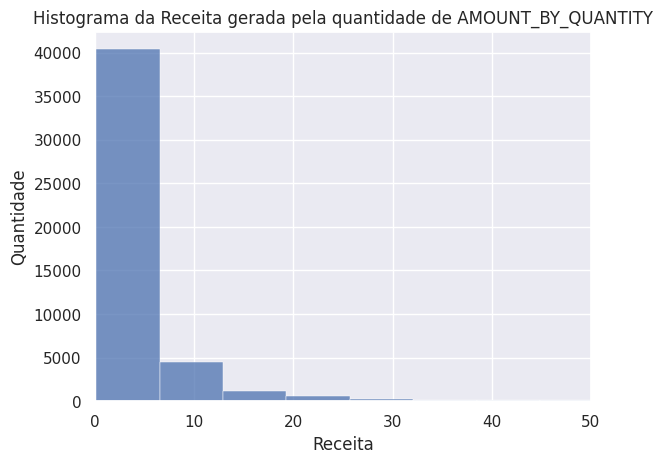

In [32]:
plot_histogram(df, 'AMOUNT_BY_QUANTITY', 50)

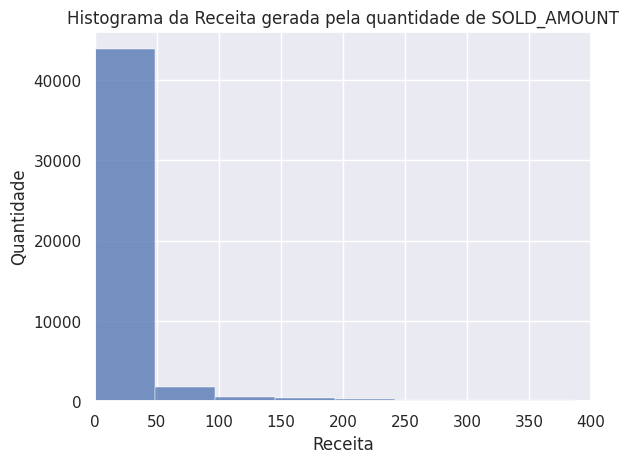

In [33]:
plot_histogram(df, 'SOLD_AMOUNT', 400)

### Análise de correlação

In [34]:
df[['INVOLVED_STOCK', 'REMAINING_STOCK_AFTER_END', 'SOLD_AMOUNT', 'AMOUNT_BY_QUANTITY', 'OFFER_DURATION_HOURS']].corr()

,INVOLVED_STOCK,REMAINING_STOCK_AFTER_END,SOLD_AMOUNT,AMOUNT_BY_QUANTITY,OFFER_DURATION_HOURS
INVOLVED_STOCK,1.000000,0.994227,0.408806,0.009075,0.099724
REMAINING_STOCK_AFTER_END,0.994227,1.000000,0.356166,0.010265,0.102040
SOLD_AMOUNT,0.408806,0.356166,1.000000,0.324667,0.070630
AMOUNT_BY_QUANTITY,0.009075,0.010265,0.324667,1.000000,0.093131
OFFER_DURATION_HOURS,0.099724,0.102040,0.070630,0.093131,1.000000


#### Duração da oferta x Receita/Quantidade

<ipython-input-29-e462b32e7126>:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=x_column, y=y_column, data=df, palette="Dark2", s=80)


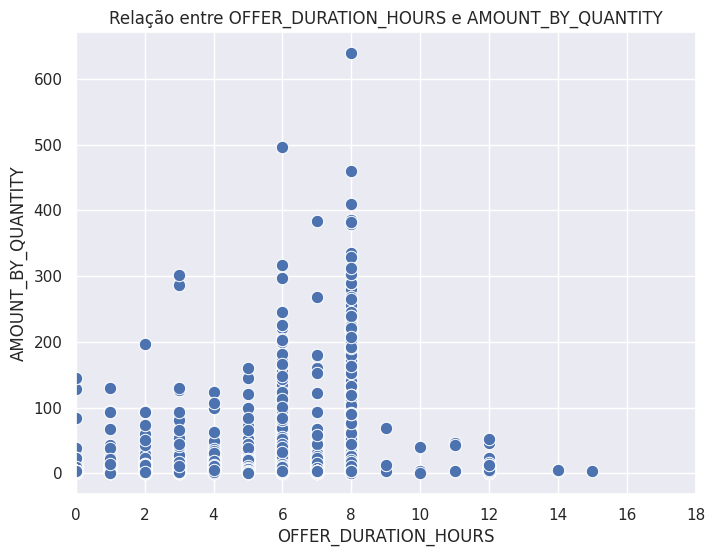

In [35]:
plot_scatter(df, "OFFER_DURATION_HOURS", "AMOUNT_BY_QUANTITY", 18, 8, 6)

In [36]:
df_filtered = remove_outliers(df, 'OFFER_DURATION_HOURS')

In [38]:
find_best_opportunity(df_filtered, 'AMOUNT_BY_QUANTITY', 'OFFER_DURATION_HOURS')

variable:  8 mean:  11.670659998573333


#### Duração da oferta x Receita

<ipython-input-29-e462b32e7126>:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=x_column, y=y_column, data=df, palette="Dark2", s=80)


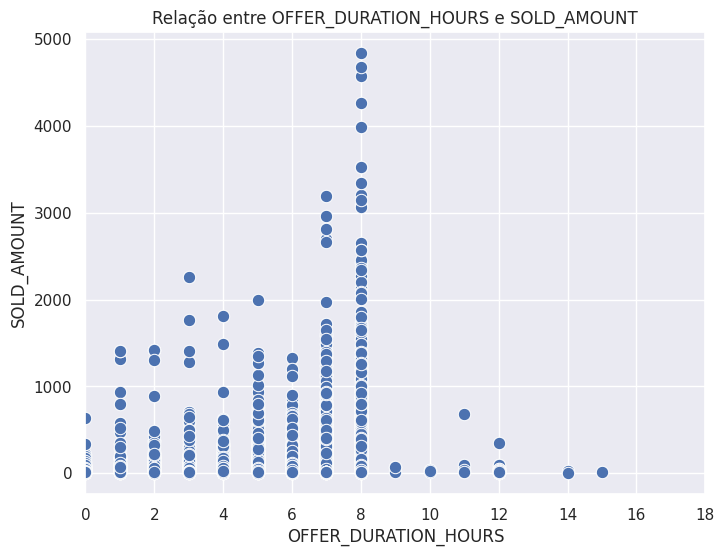

In [102]:
plot_scatter(df, "OFFER_DURATION_HOURS", "SOLD_AMOUNT", 18, 8, 6)

In [40]:
find_best_opportunity(df_filtered, 'SOLD_AMOUNT', 'OFFER_DURATION_HOURS')

variable:  7 mean:  119.80102953440718


#### Dia da semana x Receita

<ipython-input-94-f31bb662a8f0>:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="DAY_OF_WEEK", y="SOLD_AMOUNT", data=df, palette="Dark2", s=80)


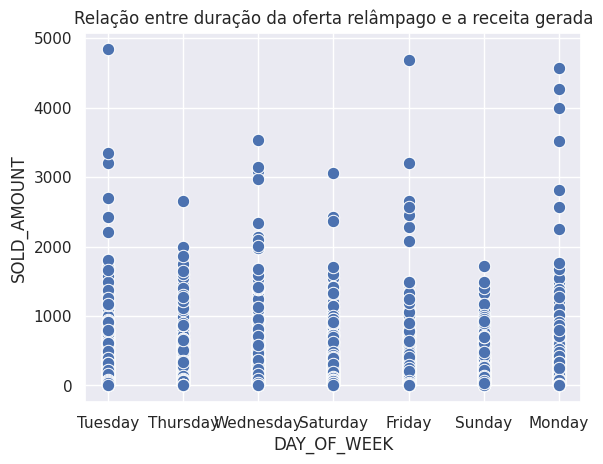

In [94]:
sns.scatterplot(x="DAY_OF_WEEK", y="SOLD_AMOUNT", data=df, palette="Dark2", s=80)
plt.title("Relação entre duração da oferta relâmpago e a receita gerada")
plt.show()

In [42]:
find_best_opportunity(df_filtered, 'AMOUNT_BY_QUANTITY', 'DAY_OF_WEEK')

variable:  Wednesday mean:  6.287922694131627


#### Dia da semana x Receita/Quantidade

<ipython-input-95-47312b32631e>:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="DAY_OF_WEEK", y="AMOUNT_BY_QUANTITY", data=df, palette="Dark2", s=80)


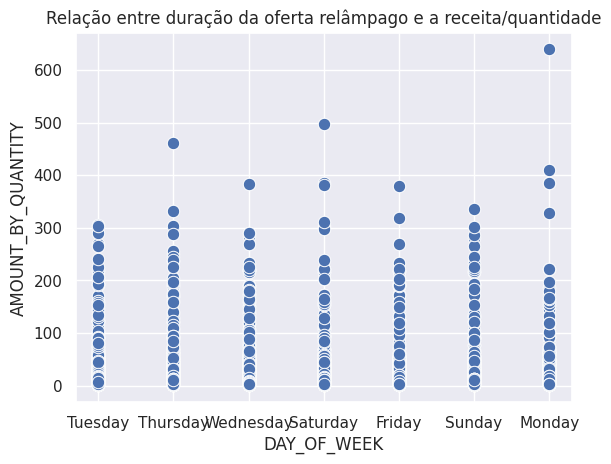

In [95]:
sns.scatterplot(x="DAY_OF_WEEK", y="AMOUNT_BY_QUANTITY", data=df, palette="Dark2", s=80)
plt.title("Relação entre duração da oferta relâmpago e a receita/quantidade")
plt.show()

In [44]:
find_best_opportunity(df_filtered, 'SOLD_AMOUNT', 'DAY_OF_WEEK')

variable:  Monday mean:  38.060776477423644


#### Hora de início da oferta x Receita

<ipython-input-96-4363af712999>:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="START_HOUR", y="SOLD_AMOUNT", data=df_sorted, palette="Dark2", s=80)


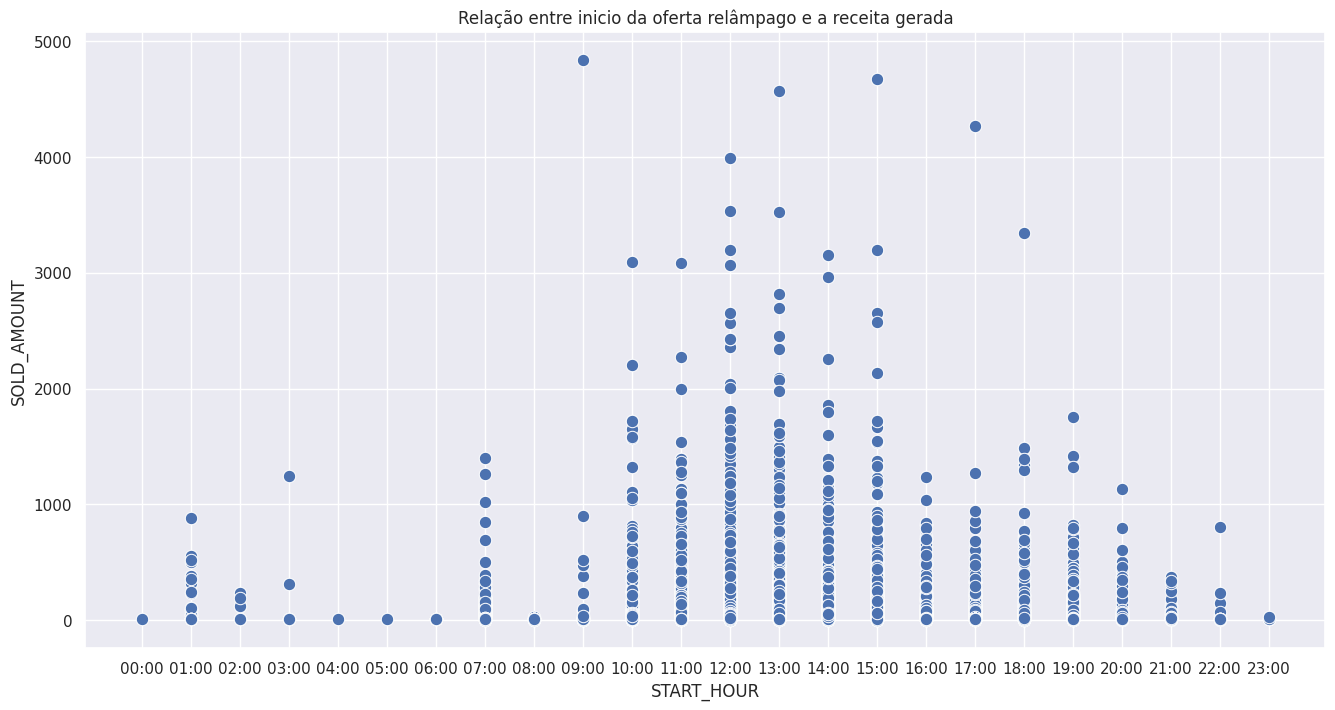

In [96]:
plt.figure(figsize=(16, 8))
df_sorted = df.sort_values(by='START_HOUR')
sns.scatterplot(x="START_HOUR", y="SOLD_AMOUNT", data=df_sorted, palette="Dark2", s=80)
plt.title("Relação entre inicio da oferta relâmpago e a receita gerada")
plt.show()

In [ ]:
# para considerar apenas horários (START_HOUR) que possui quantidade de dados com valor estatístico, fiz um recorte
# dos que possuem quantidade de pontos de dados de no mínimo 1/4 do tamanho do dataframe divido pela quantidade de horas distintas

In [46]:
df_filtered = remove_outliers(df, 'START_HOUR')

<ipython-input-97-363be8b98d21>:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="START_HOUR", y="SOLD_AMOUNT", data=df_sorted, palette="Dark2", s=80)


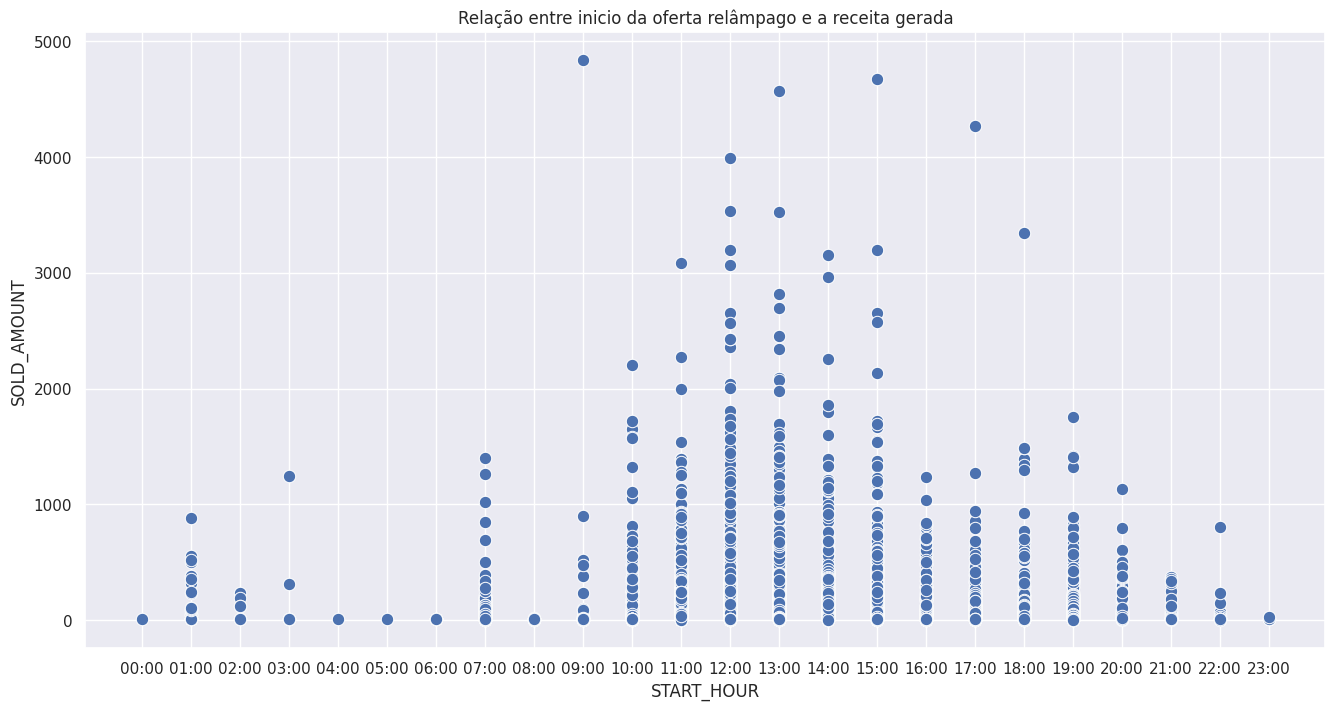

In [97]:
plt.figure(figsize=(16, 8))
df_sorted = df_filtered.sort_values(by='START_HOUR')
sns.scatterplot(x="START_HOUR", y="SOLD_AMOUNT", data=df_sorted, palette="Dark2", s=80)
plt.title("Relação entre inicio da oferta relâmpago e a receita gerada")
plt.show()

In [48]:
find_best_opportunity(df_filtered, 'SOLD_AMOUNT', 'START_HOUR')

variable:  15:00 mean:  101.38974226135866


#### Hora de início da oferta x Receita/quantidade

<ipython-input-98-afe0576fd166>:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="START_HOUR", y="AMOUNT_BY_QUANTITY", data=df_sorted, palette="Dark2", s=80)


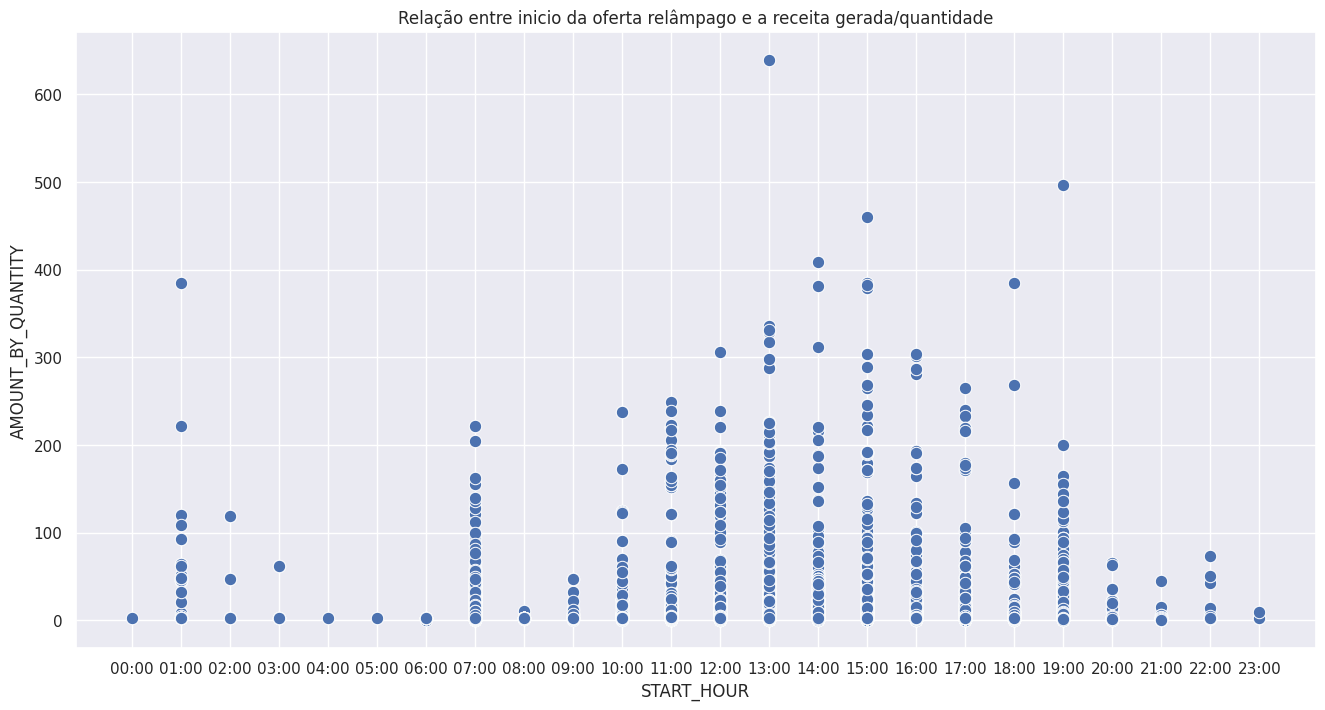

In [98]:
plt.figure(figsize=(16, 8))
df_sorted = df_filtered.sort_values(by='START_HOUR')
sns.scatterplot(x="START_HOUR", y="AMOUNT_BY_QUANTITY", data=df_sorted, palette="Dark2", s=80)
plt.title("Relação entre inicio da oferta relâmpago e a receita gerada/quantidade")
plt.show()

In [50]:
find_best_opportunity(df_filtered, 'AMOUNT_BY_QUANTITY', 'START_HOUR')

variable:  15:00 mean:  13.920071239008028


#### Receita por Vertical

In [53]:
df_filtered = remove_outliers(df, 'VERTICAL')

<ipython-input-99-d50a793cb09b>:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="VERTICAL", y="SOLD_AMOUNT", data=df_sorted, palette="Dark2", s=80)


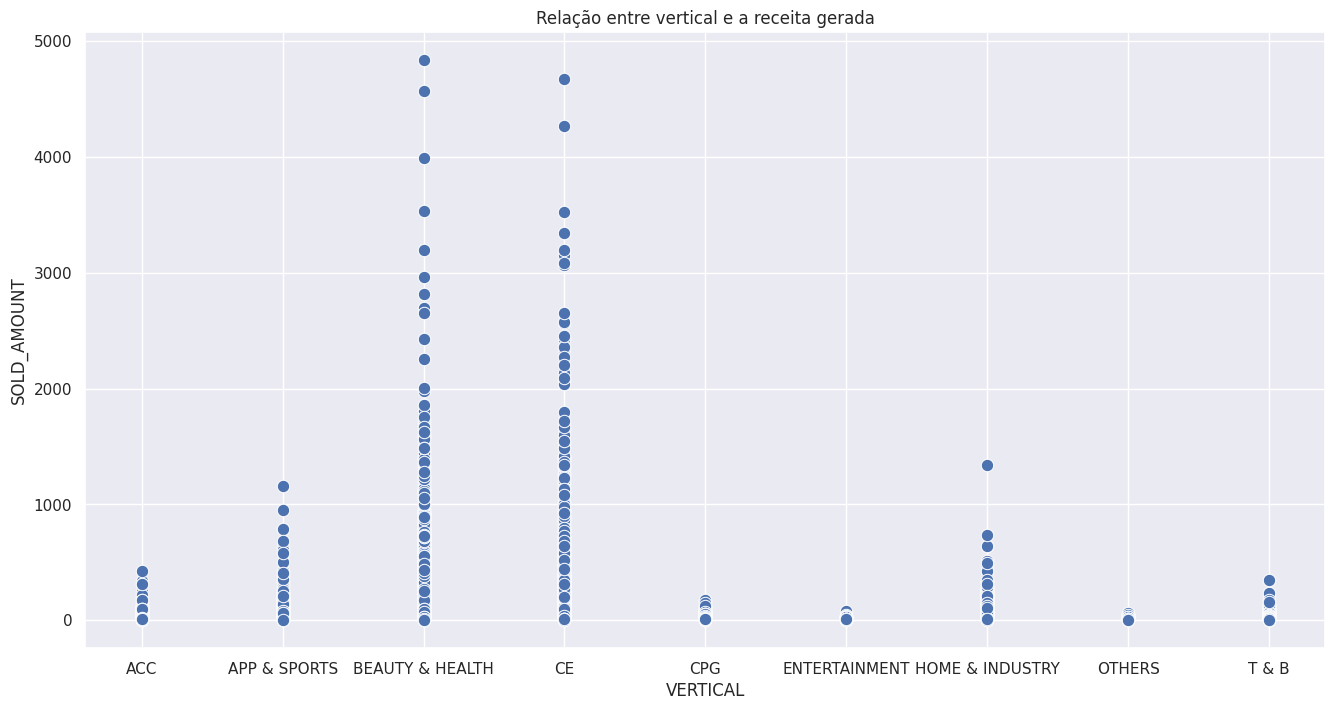

In [99]:
plt.figure(figsize=(16, 8))
df_sorted = df_filtered.sort_values(by='VERTICAL')
sns.scatterplot(x="VERTICAL", y="SOLD_AMOUNT", data=df_sorted, palette="Dark2", s=80)
plt.title("Relação entre vertical e a receita gerada")
plt.show()

In [56]:
find_best_opportunity(df_filtered, 'SOLD_AMOUNT', 'VERTICAL')

variable:  BEAUTY & HEALTH mean:  82.63830949513695


#### Receita/quantidade x Vertical

<ipython-input-100-67aa6b0c20cf>:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="VERTICAL", y="AMOUNT_BY_QUANTITY", data=df_sorted, palette="Dark2", s=80)


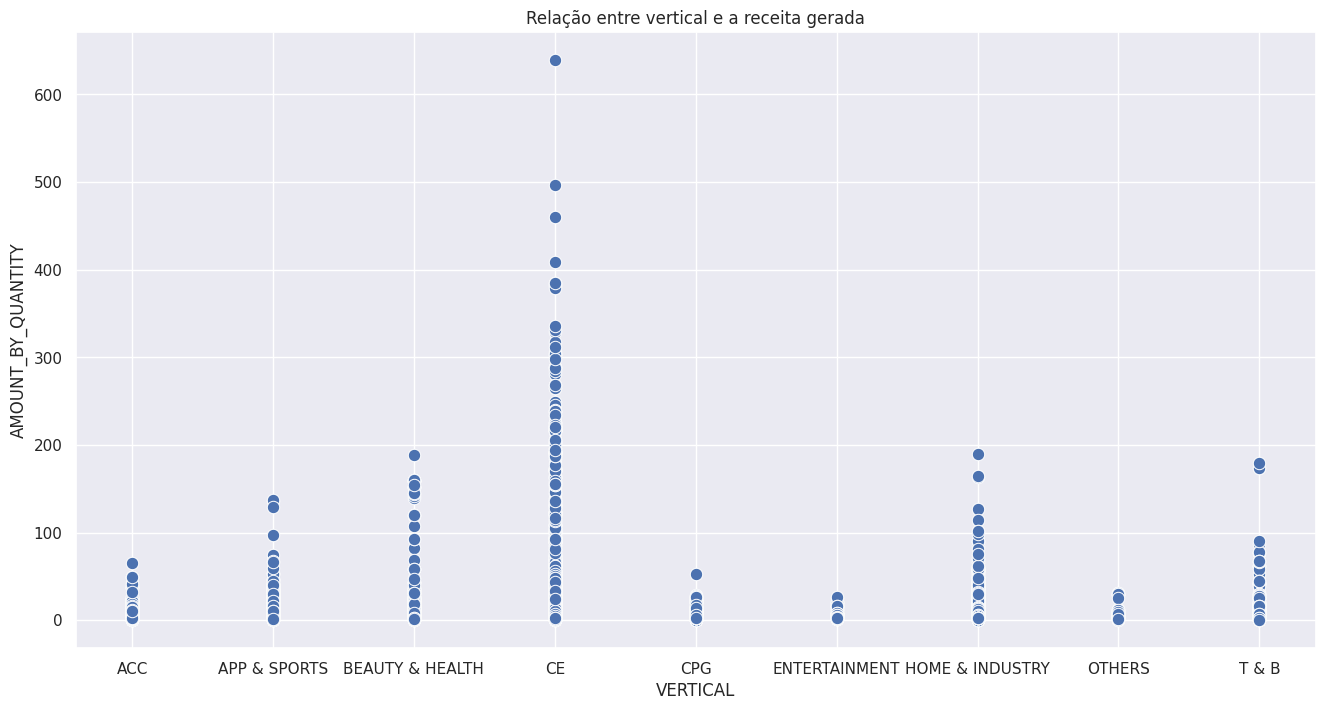

In [100]:
plt.figure(figsize=(16, 8))
df_sorted = df_filtered.sort_values(by='VERTICAL')
sns.scatterplot(x="VERTICAL", y="AMOUNT_BY_QUANTITY", data=df_sorted, palette="Dark2", s=80)
plt.title("Relação entre vertical e a receita gerada")
plt.show()

In [58]:
find_best_opportunity(df_filtered, 'AMOUNT_BY_QUANTITY', 'VERTICAL')

variable:  CE mean:  11.719302093296408


#### Dom Domain pela Receita

In [59]:
df_filtered = remove_outliers(df, 'DOM_DOMAIN_AGG1')

In [60]:
find_best_opportunity(df_filtered, 'SOLD_AMOUNT', 'DOM_DOMAIN_AGG1')

variable:  PHARMACEUTICS mean:  149.75872980355243


In [61]:
find_best_opportunity(df_filtered, 'AMOUNT_BY_QUANTITY', 'DOM_DOMAIN_AGG1')

variable:  MOBILE mean:  15.156299178948295


#### Domain ID pela Receita

In [62]:
df_filtered = remove_outliers(df, 'DOMAIN_ID')

In [63]:
find_best_opportunity(df_filtered, 'SOLD_AMOUNT', 'DOMAIN_ID')

variable:  MLM-CELLPHONES mean:  533.4419299557032


In [64]:
find_best_opportunity(df_filtered, 'AMOUNT_BY_QUANTITY', 'DOMAIN_ID')

variable:  MLM-OXYGEN_CONCENTRATORS mean:  93.1166044172582


### Avaliação de problemas em estoque

In [65]:
# filtrar e avaliar padrões de itens com problema de estoque
df_problema_estoque = df[df['REMAINING_STOCK_AFTER_END'] < 0].copy()

<ipython-input-101-90a1f3a39c3c>:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="VERTICAL", y="REMAINING_STOCK_AFTER_END", data=df_sorted, palette="Dark2", s=80)


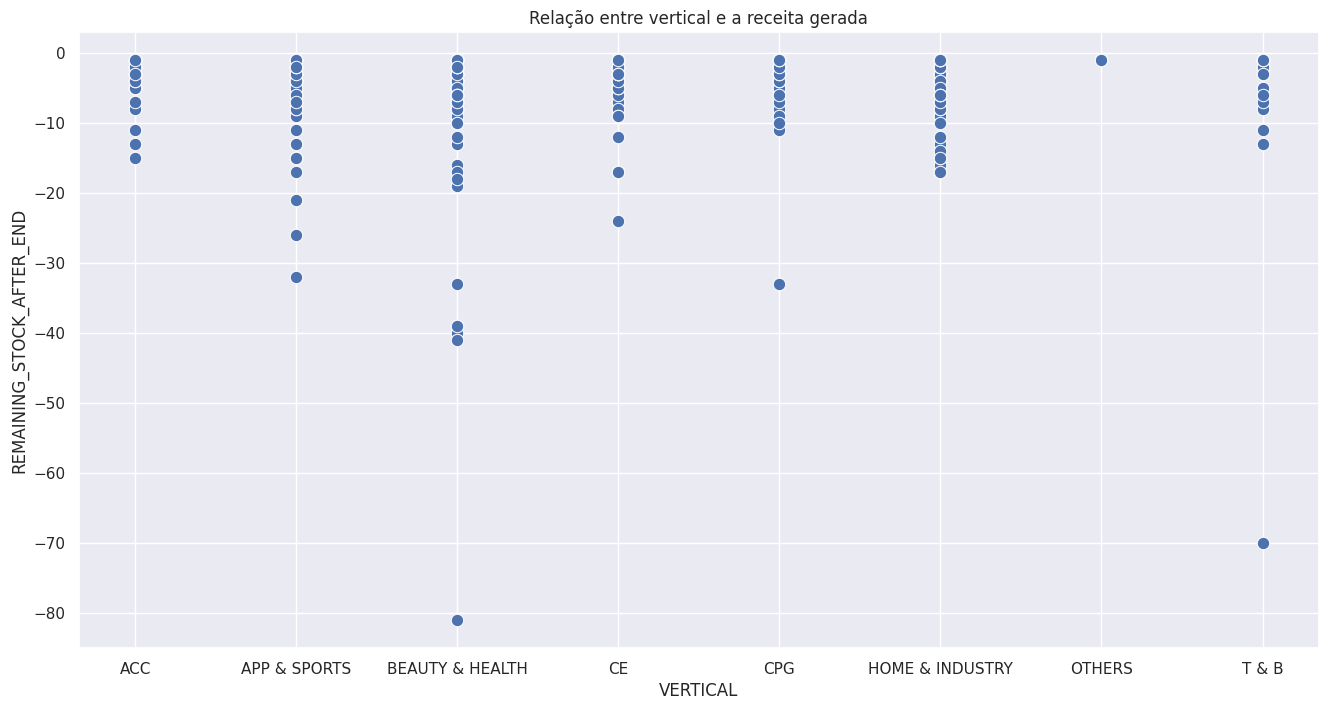

In [101]:
plt.figure(figsize=(16, 8))
df_sorted = df_problema_estoque.sort_values(by='VERTICAL')
sns.scatterplot(x="VERTICAL", y="REMAINING_STOCK_AFTER_END", data=df_sorted, palette="Dark2", s=80)
plt.title("Relação entre vertical e a receita gerada")
plt.show()

In [67]:
min(df_problema_estoque['REMAINING_STOCK_AFTER_END'])

-192

In [68]:
df = df[df['REMAINING_STOCK_AFTER_END'] != -192].copy()
df_problema_estoque = df[df['REMAINING_STOCK_AFTER_END'] < 0].copy()

In [69]:
df['INVOLVED_STOCK'][df['REMAINING_STOCK_AFTER_END'] > 0].mean()

37.3651711166162

In [70]:
df_problema_estoque['INVOLVED_STOCK'][df_problema_estoque['REMAINING_STOCK_AFTER_END'] < 0].mean()

15.88985736925515

In [71]:
df_estoque_ref = df[df['REMAINING_STOCK_AFTER_END'] > 0].copy()
dic = {}
for domain in df['DOMAIN_ID'].unique():
    
    media_ideal = df['REMAINING_STOCK_AFTER_END'][df['DOMAIN_ID'] == domain].mean()
    media_ideal = int(media_ideal)
    dic[domain] = media_ideal

### Análise de oportunidades

Existem duas premissas a seguir: a primeira se quiser potencializar a receita/quantidade focar nas melhores oportunidades de AMOUT_QUANTITY e a outra é se quiser focar na receita independente da quatidade seria AMOUNT. Ao me ver a outra opção faz mais sentido, pois podemos potencializar a receita com menos volume o que traria menos custo e dificuldade para operação.

Insights gerados **
1. Identificado que a duração em horas da oferta relâmpago (OFFER_DURATION_HOURS) tende a potencializar o retorno de receita (SOLD_AMOUNT), quando nas durações e 7 horas e para AMOUNT_BY_QUANTITY 8 horas.
2. Não é recomendado duração da oferta relâmpago (OFFER_DURATION_HOURS) acima de 8 horas, pois não temos aumento proporcional após 8 horas de duração da oferta.
3. Identificado um outlier de duração de oferta (OFFER_DURATION_HOURS), com DOMAIN_ID = MLM-SLEEPING_MASKS, ficando 104 horas na oferta relâmpago e o valor de SOLD_AMOUNT teve uma pequena variação em relação a média de 10,3.
4. O melhor dia para uma oferta relâmpago é segunda-feira, na qual temos a maior média de receita (SOLD_AMOUNT). Contudo para o AMOUNT_BY_QUANTITY é Quarta-feira
5. O melhor horário para uma oferta relâmpago são as 15horas, na qual temos a maior média de receita (SOLD_AMOUNT) quanto para AMOUNT_BY_QUANTITY.
6. A vertical que gera a maior receita (SOLD_AMOUNT) é a vertical 'BEAUTY & HEALTH' e para é AMOUNT_BY_QUANTITY CE.
7. O domínio que gera a maior receita (SOLD_AMOUNT) é o domínimo 'PHARMACEUTICS' e visando AMOUNT_BY_QUANTITY é MOBILE
8. O domínio_id que gera a maior receita (SOLD_AMOUNT) é o domínimo_id 'MLM-CELLPHONES' e visando AMOUNT_BY_QUANTITYMLM é OXYGEN_CONCENTRATORS.
9. Avaliando os itens com estoque negativo após a oferta relâmpago, percebemos uma diferença em relação ao estoque inicial, casos em que não temos quebra de estoque o estoque inicial média é aproximadamente 37 itens enquanto casos em que tivemos quebra de estoque o estoque inicial é aproximadamente 16 itens, gerando a necessidade de iniciar uma promoção relâmpago com o estoque maior para evitar quebras.
9.1 abaixo indico o estoque ideal inicial por produto

In [ ]:
dic

{'MLM-BIRD_FOODS': 4,
 'MLM-ANIMAL_AND_PET_PRODUCTS': 8,
 'MLM-SPEAKERS': 12,
 'MLM-HEADPHONES': 31,
 'MLM-SMART_SPEAKERS': 8,
 'MLM-ELECTRONIC_PRODUCTS': 25,
 'MLM-CATS_AND_DOGS_FOODS': 3,
 'MLM-CLOTHING': 9,
 'MLM-PARTY_SUPPLIES': 7,
 'MLM-TOYS_AND_GAMES': 7,
 'MLM-BEAUTY_AND_PERSONAL_CARE_SUPPLIES': 13,
 'MLM-INDUSTRIAL_AND_COMMERCIAL_EQUIPMENT': 10,
 'MLM-FISH_FOODS': 4,
 'MLM-SHOWER_HEADS': 7,
 'MLM-SOAP_AND_DETERGENT_DISPENSERS': 21,
 'MLM-BLOUSES': 12,
 'MLM-MUGS': 16,
 'MLM-THERMOSES': 9,
 'MLM-KITCHEN_POTS': 11,
 'MLM-FLATWARE_SETS': 24,
 'MLM-KITCHEN_MOLDS': 35,
 'MLM-DRINKING_GLASSES': 9,
 'MLM-KITCHEN_SUPPLIES': 7,
 'MLM-KITCHEN_THERMOMETERS': 91,
 'MLM-KITCHEN_COOKWARE_SETS': 46,
 'MLM-MEASURING_CUPS_AND_JUGS': 69,
 'MLM-MANUAL_DRINKING_WATER_PUMPS': 4,
 'MLM-FRYING_PANS_WOKS_GRIDDLES_AND_GRILL_PANS': 24,
 'MLM-BOOKS': 5,
 'MLM-DOG_SUPPLEMENTS': 8,
 'MLM-CATS_AND_DOGS_TREATS': 10,
 'MLM-FLEA_AND_TICK_TREATMENTS': 8,
 'MLM-STICKERS': 7,
 'MLM-VEHICLE_LED_BULBS': 7,
 'MLM-VE